<span style="font-size: 22px; font-family: Arial, sans-serif; font-weight: bold;">The purpose of this workbook is to conduct a predictive analysis of the IXIC stock price. Input data comes from Yahoo Finance and includes historical data from Nasdaq Composite. In this workbook, I will try to explore several predictive analytics models and then choose the best one to predict the next day's closing price. In this project, I will use a slightly simplistic approach to predictive analytics. In stock price analysis, a diverse spectrum of stock market indicators should be used, but in my project, I will only use closing prices.</span>

<span style="font-size: 22px; font-family: Arial, sans-serif; font-weight: bold;">1. Importing required libraries</span>

In [1]:
import pandas as pd 
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.model_selection import train_test_split
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima

<span style="font-size: 22px; font-family: Arial, sans-serif; font-weight: bold;">2. Input data processing</span>

In [2]:
stock_data = pd.read_csv('IXIC.csv', index_col='Date', parse_dates = True)
stock_data.head(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1971-02-05,100.000000,100.000000,100.000000,100.000000,100.000000,0
1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0


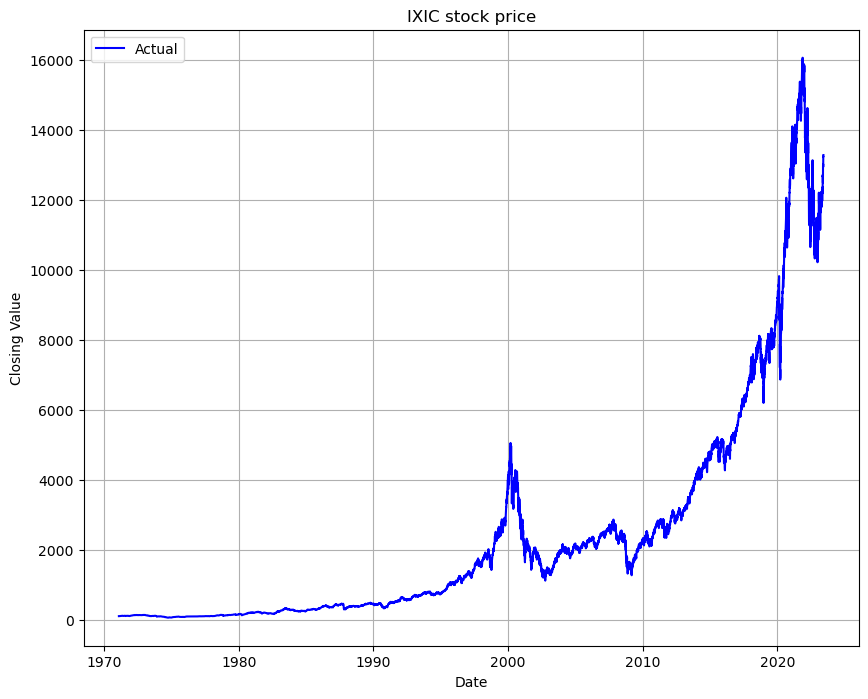

In [3]:
#plotting the data
plt.figure(figsize=(10, 8))
plt.plot(stock_data.index, stock_data['Close'], color = 'blue', label = "Actual")

#automatically formating date ticsks 
locator = mdates.AutoDateLocator()  
formatter = mdates.ConciseDateFormatter(locator) 

#setting the locator and formatter for x axis
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

#configuring the plot area
plt.title('IXIC stock price')
plt.xlabel('Date')
plt.ylabel('Closing Value')
plt.legend()
plt.grid()

plt.show()

<span style="font-size: 22px; font-family: Arial, sans-serif; font-weight: bold;">3. Linear regression</span>

<span style="font-size: 16px; font-family: Arial, sans-serif;">Linear regression is a statistical method that assumes a linear relationship between the dependent variable and one or more independent variables. It's used in predictive analysis by using historical data to estimate future values by fitting a straight line to data points, which allows for forecasting and trend analysis. Linear regression in stock price analysis won't provide an accurate prediction for the next day's price but will help estimate the trend of a given period.</span>

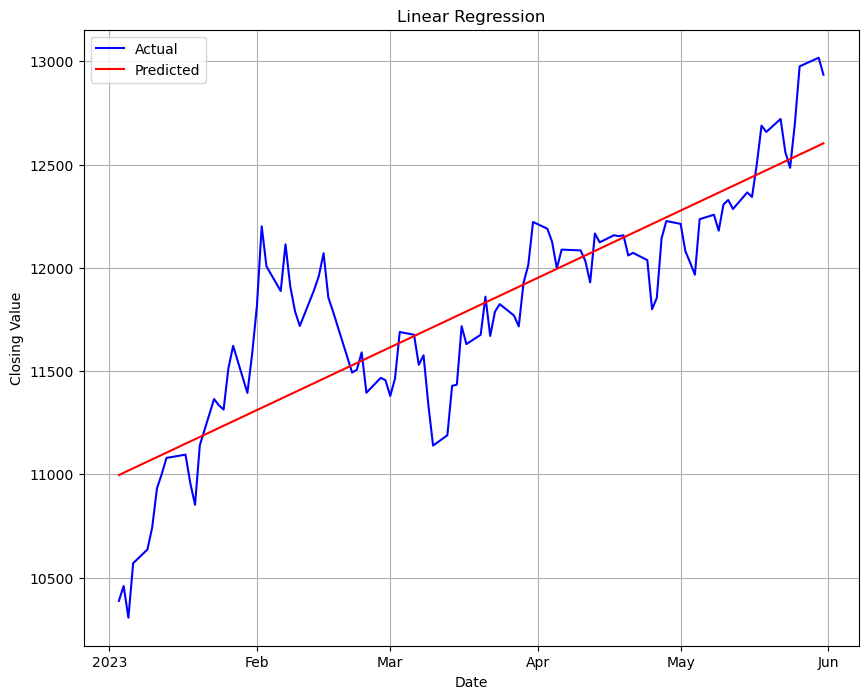

In [4]:
def LinearModel(start_date,end_date):
    #sourcing the data and setting the date column as index
    stock_data = pd.read_csv('IXIC.csv', index_col='Date', parse_dates = True)
    stock_data = stock_data[(stock_data.index > start_date) & (stock_data.index < end_date)]

    #defining independent and dependent variables
    dependent_var = stock_data['Close']
    independent_var = stock_data.index
    independent_var = independent_var.map(dt.datetime.toordinal)
    
    #defining X nad y variables. X variable needs to be assigned to a 2D matrix (model requirement)
    X = pd.DataFrame(independent_var, columns=['Date'])
    y = dependent_var     
    

    #fittig the linear regression model
    model = LinearRegression()
    model.fit(X,y)

    #generating predictions for dependent variable based on independent variable
    y_pred = model.predict(X)
    #y_pred_future = model.predict(future_X)

    #plotting the data
    plt.figure(figsize=(10, 8))
    plt.plot(X['Date'].map(dt.datetime.fromordinal), y, color='blue', label='Actual')
    plt.plot(X['Date'].map(dt.datetime.fromordinal), y_pred, color='red', label='Predicted')
    #plt.plot(future_X['Date'].map(dt.datetime.fromordinal), y_pred_future, color='green', label='Forecast')

    #automatically formating date ticsks 
    locator = mdates.AutoDateLocator()  
    formatter = mdates.ConciseDateFormatter(locator) 

    #setting the locator and formatter for x axis
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)

    #configuring the plot area
    plt.title('Linear Regression')
    plt.xlabel('Date')
    plt.ylabel('Closing Value')
    plt.legend()
    plt.grid()

    return plt.show()
    
LinearModel("2023-01-01",'2023-06-01')

<span style="font-size: 16px; font-family: Arial, sans-serif;">For the selected date range the linear regression model is working reasonably well. It's showing the upward trend of the closing price, but it's not capturing the dynamics of the spike observed during Feb. Let's try to extend the date range and include the year 2022.</span>


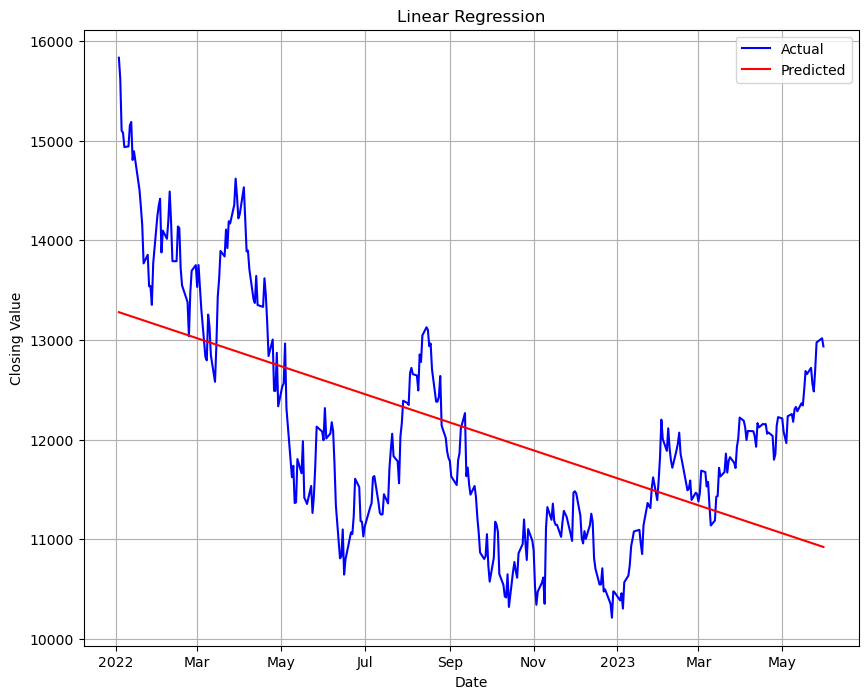

In [5]:
LinearModel("2022-01-01",'2023-06-01')

<span style="font-size: 16px; font-family: Arial, sans-serif;">In this scenario, our linear regression might be misleading. The straight line will correctly indicate the trend during the entire date range but will not capture recent behavior. In this scenario, the overall trend is predicting a decrease whereas the rising trend is visible since the beginning of 2023. In this situation, we need to find a method to include recent behavior in the trendline.</span>

<span style="font-size: 22px; font-family: Arial, sans-serif; font-weight: bold;">4. Polynominal regression</span>

<span style="font-size: 16px; font-family: Arial, sans-serif;">Polynomial regression is a forecasting technique used for non-linear relationships between the dependent variable and independent variables by fitting polynomial functions. It allows to fit of a flexible curve to describe the variables and to produce more precise and nuanced forecasting predictions.</span>

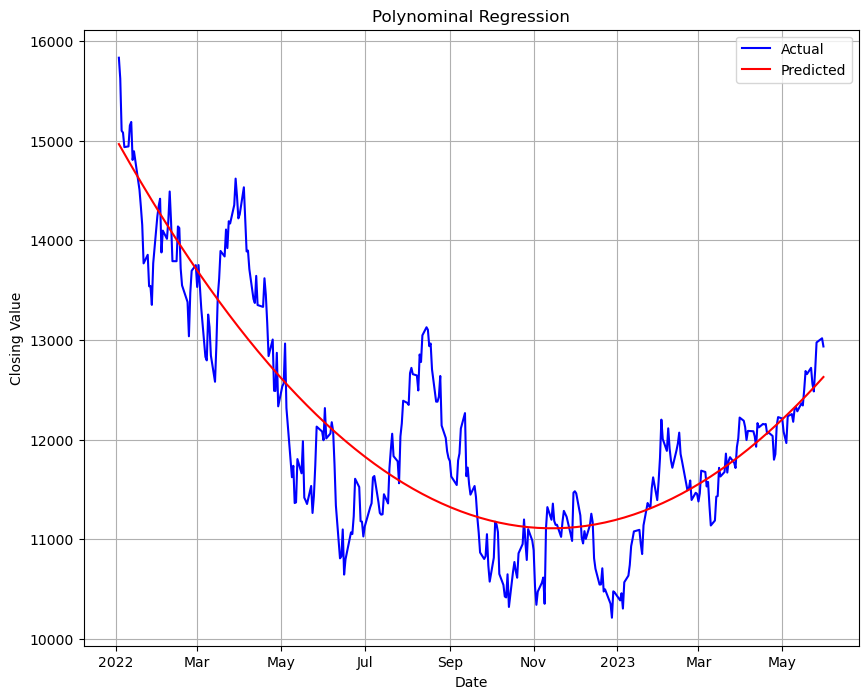

In [6]:
def PolynominalModel(start_date,end_date,degree):   
    #sourcing the data and setting the date column as index
    stock_data = pd.read_csv('IXIC.csv', index_col='Date', parse_dates = True)
    stock_data = stock_data[(stock_data.index > start_date) & (stock_data.index < end_date)]

    #stock_data = pd.read_csv('IXIC.csv')
    #stock_data['Date'] = pd.to_datetime(stock_data['Date'])

    # Filter the data from "2023-01-01" onwards
    #stock_data = stock_data[stock_data['Date'] > "2022-01-01"]

    #defining x and y value for the polynomynal regression model. Changing the format of date values to match the requirements of the model
    x = stock_data.index.map(pd.Timestamp.toordinal)
    y = stock_data['Close']

    #defining a degree to be used in the model. I'm looking for a quadratic curve, so setting this parameter to 2  

    #fittig the polynominal regression model to x and y data points 
    model = np.polyfit(x, y, degree)

    #calculating values predicted for x using previously fitted model
    y_pred = np.polyval(model, x)

    #plotting the data
    plt.figure(figsize=(10, 8))
    plt.plot(stock_data.index, y, color = 'blue', label='Actual')
    plt.plot(stock_data.index, y_pred, color = 'red', label='Predicted')

    #automatically formating date ticsks 
    locator = mdates.AutoDateLocator()  
    formatter = mdates.ConciseDateFormatter(locator) 

    #setting the locator and formatter for x axis
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)

    #configuring the plot area
    plt.title('Polynominal Regression')
    plt.xlabel('Date')
    plt.ylabel('Closing Value')
    plt.legend()
    plt.grid()

    return plt.show()

#defining a degree to be used in the model. I'm looking for a quadratic curve, so setting this parameter to 2  
PolynominalModel('2022-01-01','2023-06-01',2)

<span style="font-size: 16px; font-family: Arial, sans-serif;">The quadratic curve seems to fit the data set much better than the linear regression and also correctly captures the recent trend. It is also possible to find a good fit for data with more than one change in trend.</span>

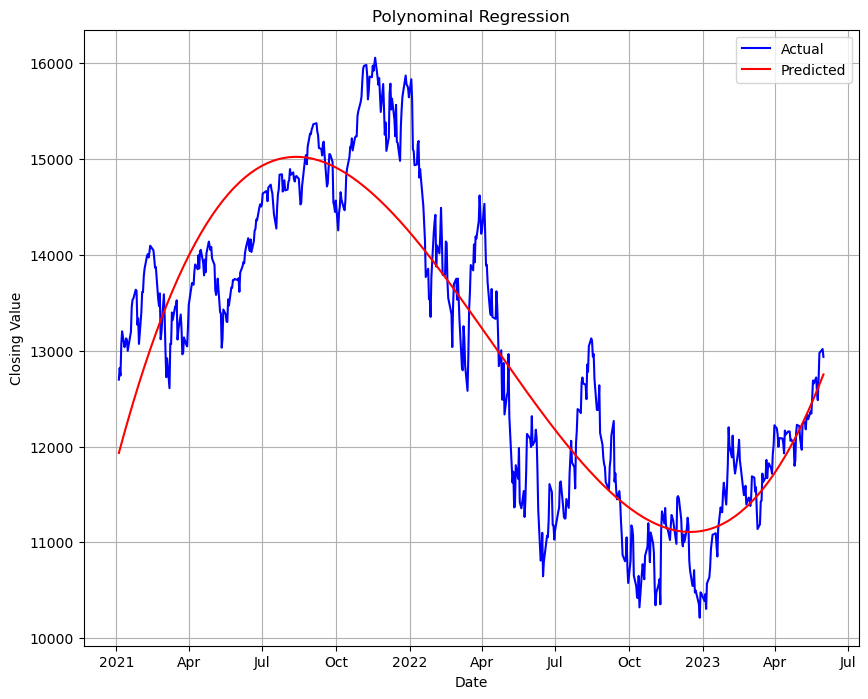

In [7]:
PolynominalModel('2021-01-01','2023-06-01',3)

<span style="font-size: 16px; font-family: Arial, sans-serif;">Polynomial functions are quite versatile in fitting the model but eventually, when extending the date range, we would find the data set in which the polynomial function cannot fit properly. Moreover, produced predictions will only indicate the trend in our dataset and are not suitable to indicate the next-day price.</span>

<span style="font-size: 22px; font-family: Arial, sans-serif; font-weight: bold;">5. ARIMA</span>

<span style="font-size: 16px; font-family: Arial, sans-serif;">ARIMA model is a time series forecasting model which consists of autoregressive, moving average, and differencing components which can be individually tweaked and adjusted according to data set requirements. ARIMA-family models are widely used in various industries for both short-term and long-term forecasting tasks. </span>

<span style="font-size: 16px; font-family: Arial, sans-serif;">To start with the ARIMA forecast we need to check if our dataset is static. To do it we can use an Augmented Dickey-Fuller (ADF) test. This test allows to check the dataset against H0 and H1 hypotheses. The H0 hypothesis is assuming that the dataset is non-stationary and the H1 hypothesis is assuming stationarity. We can reject one of the hypotheses by assessing the p-value of the ADF test. Another step would be to choose the ARIMA model and determine the optimal p,q, and d parameters. To do it we can use the auto ARIMA function which would test the parameters automatically and suggest the best fit. </span>

In [8]:
#sourcing the data and setting the date column as index
stock_data = pd.read_csv('IXIC.csv', index_col="Date", parse_dates = True)
stock_data = stock_data[(stock_data.index > '2022-01-01') & (stock_data.index < '2023-06-01')]

#using adfuller module to run the test
test = adfuller(stock_data['Close'])

#sourcing the p value from the test 
p_val = test[1]

#checking the P value against the 0.05 significance level to confirm if null hypothesis H0 (non-stationary) can be rejected
if p_val < 0.05:
    print("The dataset is stationary.")
else:
    print("The dataset is not showing static characteristics, it might be non-stationary.")

#running the auto ARIMA function to determine the best model and optimal p,q,d parameters. 
auto_arima(stock_data['Close'],trace = True, D=1)

The dataset is stationary.
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4824.765, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4819.541, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4821.522, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4821.556, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4818.024, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4822.142, Time=0.27 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.799 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

<span style="font-size: 16px; font-family: Arial, sans-serif;">The outcome of the ADF test for a relatively narrow date range shows that the data set could be considered static. However, for a broader date range, our data set is not stationary and predictions produced by the ARIMA model for this dataset might not be accurate since ARIMA is optimized to work on stationary datasets. To change this dataset into a stationary one we should implement differencing, but for simplicity's sake this step will be skipped.</span>

<span style="font-size: 16px; font-family: Arial, sans-serif;">Auto ARIMA function suggested the optimal model for the dataset and p,q, and d parameters. This information will be considered in the next steps.
</span>


MAPE: 0.00819759355585508


<Figure size 640x480 with 0 Axes>

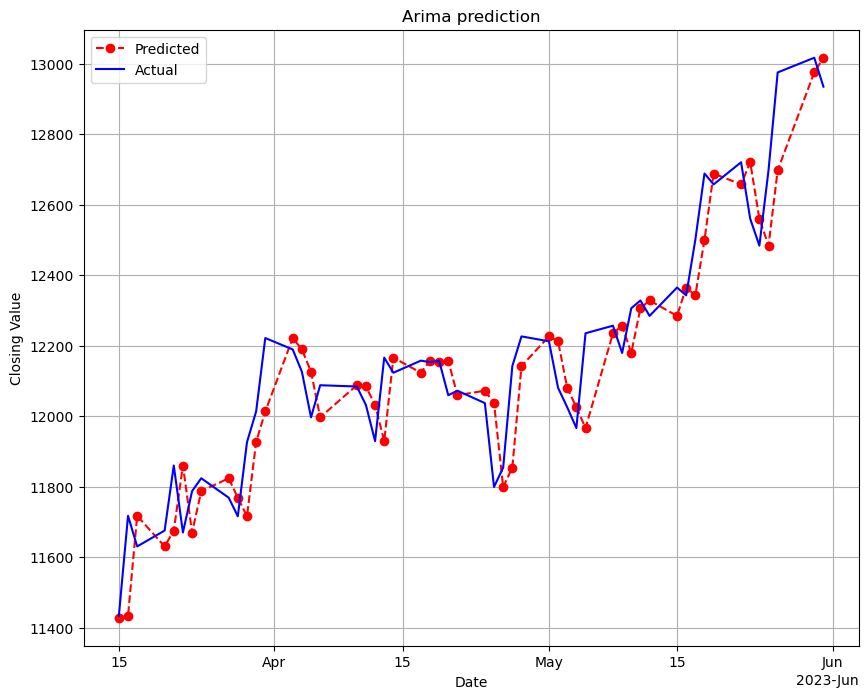

<Figure size 640x480 with 0 Axes>

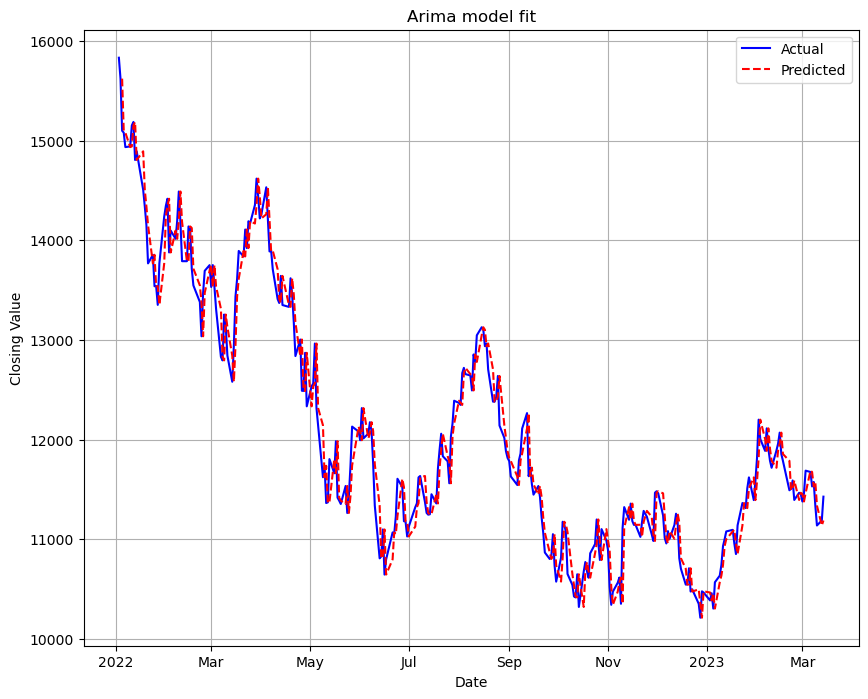

In [9]:
def ARIMAModel(start_date, end_date, parameters,training_percentage):
    #sourcing the data and setting the date column as index
    training_data = []
    stock_data = pd.read_csv('IXIC.csv', index_col="Date", parse_dates = True)
    stock_data = stock_data[(stock_data.index > start_date) & (stock_data.index < end_date)]

    #calculating the index split
    split_index = int(len(stock_data) * training_percentage)

    #performing the split for train and test dat
    training_data = list(stock_data[:split_index]['Adj Close'])
    testing_data = list(stock_data[split_index:]['Adj Close'])

    #fitting the ARIMA model
    model = ARIMA(training_data, order = parameters)
    result = model.fit()
    
    #generating predictions for training data
    y_train_pred = result.predict(start=0, end=len(training_data)-1)

    #creating an empty list to hold forecasted values
    forecasted_values = []
    
    #defining the iterations amount 
    n = len(testing_data)

    #for each entry in testing data set generate a prediction for next day, append it to forecasted values list, and append actual value to a training dataset
    for i in range(n):
        model = ARIMA(training_data, order = parameters)
        model_fit = model.fit()
        output = model_fit.forecast()
        y_pred = output[0]
        forecasted_values.append(y_pred)
        actual_test_value = testing_data[i]
        training_data.append(actual_test_value)

    #plotting the first figure
    plt.figure()
    plt.figure(figsize=(10, 8))
    plt.plot(stock_data[split_index:].index, forecasted_values, color = 'red', marker = 'o', linestyle = 'dashed', label = 'Predicted')
    plt.plot(stock_data[split_index:].index, testing_data, color = 'blue', label = 'Actual')

    #automatically formating date ticsks 
    locator = mdates.AutoDateLocator()  
    formatter = mdates.ConciseDateFormatter(locator) 

    #setting the locator and formatter for x axis
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)

    #configuring the plot area
    plt.title('Arima prediction')
    plt.xlabel('Date')
    plt.ylabel('Closing Value')
    plt.legend()
    plt.grid()

    #plotting the second figure
    plt.figure()
    plt.figure(figsize=(10, 8))
    plt.plot(stock_data[:split_index].index, training_data[:split_index], color = 'blue', label = 'Actual')
    plt.plot(stock_data[2:split_index].index, y_train_pred[2:], color = 'red', linestyle = 'dashed', label = 'Predicted')

    #automatically formating date ticsks 
    locator = mdates.AutoDateLocator()  
    formatter = mdates.ConciseDateFormatter(locator) 

    #setting the locator and formatter for x axis
    plt.gca().xaxis.set_major_locator(locator)
    plt.gca().xaxis.set_major_formatter(formatter)

    #configuring the plot area
    plt.title('Arima model fit')
    plt.xlabel('Date')
    plt.ylabel('Closing Value')
    plt.legend()
    plt.grid()

    MAPE = np.mean(np.abs(np.array(forecasted_values) - np.array(testing_data))/np.abs(testing_data))

    return print("MAPE: "+str(MAPE))

ARIMAModel('2022-01-01','2023-06-01',(0,1,0),0.85)

<span style="font-size: 16px; font-family: Arial, sans-serif;">The ARIMA model is fitting the data quite well and it's able to provide some accurate predictions. Unfortunately, a significant portion of the prediction is lagged and it's indicating the daily variations accurately. However, the mean absolute percentage error (MAPE) indicates that only the predictions are only around 1% different than actual values. It's still possible to improve this model by including more variables in the analysis, applying differencing, experimenting with ARIMA parameters, or choosing different prediction algorithms.
</span>